**Fusion Notebook**

*from Kai Benning
(kai.benning@uni-wuppertal.de || kai.benning@gmx.de)
| Fusion Notebook v1.0
| 4.Juni.2019*

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy import ndimage

In [2]:
mr_image = plt.imread("images/mr_image.jpg")
pet_image = plt.imread("images/pet_image.jpg")

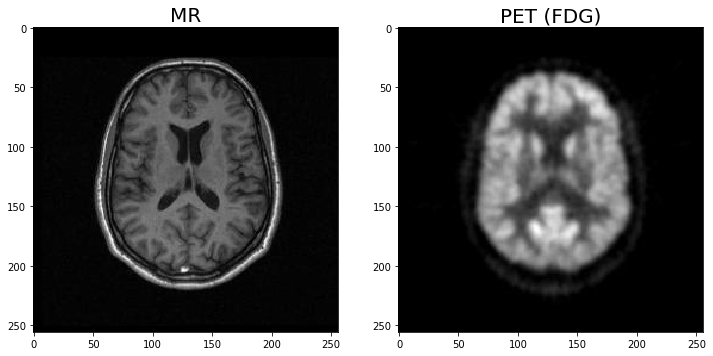

In [3]:
plt.figure(figsize=(12,16))
plt.subplot(121)
plt.title("MR", fontsize=20)
plt.imshow(mr_image)
plt.subplot(122)
plt.title("PET (FDG)", fontsize=20)
plt.imshow(pet_image)
plt.show()

*Convert the RGB-JPGs to grayscale and set a arbitrary threshold on the PET-Image*

In [4]:
def pet_rgb_to_grayscale(arr,thresh=0.3):
    tmp = arr[:,:,0] * 0.21 + arr[:,:,1] * 0.72 + arr[:,:,2] * 0.07
    tmp /= 255
    tmp -= thresh
    tmp[tmp < 0.0] = 0
    tmp /= np.amax(tmp)
    return tmp

def mr_rgb_to_grayscale(arr):
    tmp = arr[:,:,0] * 0.21 + arr[:,:,1] * 0.72 + arr[:,:,2] * 0.07
    tmp /= 255
    return tmp

In [5]:
mr_image_mod = mr_rgb_to_grayscale(mr_image)
pet_image_mod = pet_rgb_to_grayscale(pet_image)

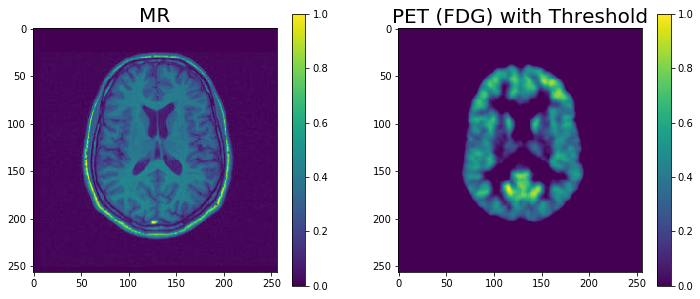

In [6]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title("MR", fontsize=20)
plt.imshow(mr_image_mod)
plt.colorbar()
plt.subplot(122)
plt.title("PET (FDG) with Threshold", fontsize=20)
plt.imshow(pet_image_mod)
plt.colorbar()
plt.show()

*For the MR we will use the gray-colormap and for the PET we will use the nipy_spectral-colormap.*

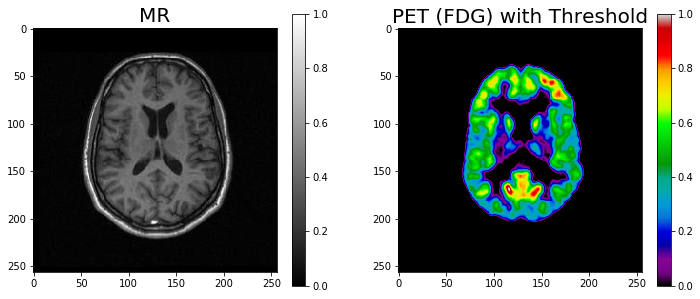

In [7]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title("MR", fontsize=20)
plt.imshow(mr_image_mod,cmap = "gray")
plt.colorbar()
plt.subplot(122)
plt.title("PET (FDG) with Threshold", fontsize=20)
plt.imshow(pet_image_mod,cmap = "nipy_spectral")
plt.colorbar()
plt.show()

*The grays are a more intuitive for the anatomy (like we know it from simple X-Ray-Films). PET Images show an activity distribution: we want black for the Zeroes (a good anchor for our eyes) and hot-/cold color scheme for the activity.*

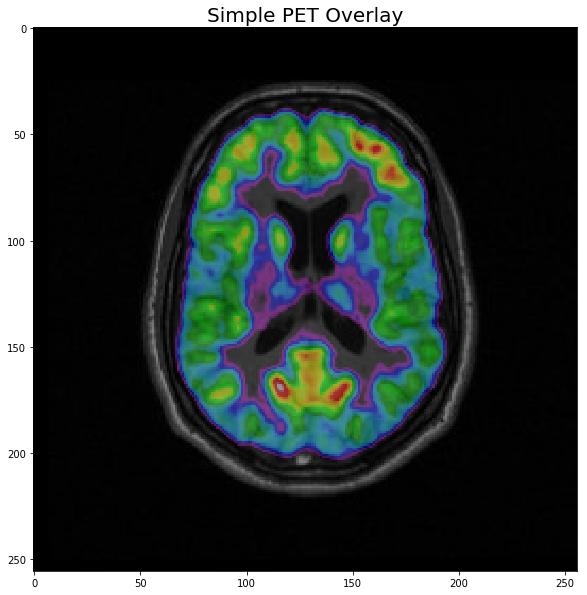

In [8]:
plt.figure(figsize=(10,10))
plt.title("Simple PET Overlay", fontsize=20)
plt.imshow(mr_image_mod,cmap = "gray",alpha = 1.0)
plt.imshow(pet_image_mod,cmap = "nipy_spectral",alpha = 0.5)
plt.show()

*A simple overlay is a valid choice for a rough overview, but the PET-Image hides the MR-texture. Now let us do the more sophisticated checkerboard-fusion, in this fusion-mode we imagine the black and white squares of a chess-board and give the MR-Image the black squares and the PET-Image the white squares. Of course, if the PET-square has a zero intensity, we can just give the square to the MR-Image. (Positron Emission Tomography - Physical Background and Applications, Habilitationsschrift, p.115, 1997, Uwe Pietrzyk)* 

In [9]:
def mr_pet_checkerboard(mr,pet):

    mr_gray = cm.gray(mr)
    pet_hot  = cm.nipy_spectral(pet)
    
    x_y_dim = pet.shape[0]

    new = mr_gray
    for i in range(x_y_dim):
        for j in range(x_y_dim):
            if np.sum(pet_hot[i,j,:]) > 1:
                if i%2 == 0 and j%2 == 0:
                    new[i,j,:] = pet_hot[i,j,:]
                if (i+1)%2 == 0 and (j+1)%2 == 0:
                    new[i,j,:] = pet_hot[i,j,:]
    return new

In [10]:
checkerboard_fused_image = mr_pet_checkerboard(mr_image_mod,pet_image_mod)

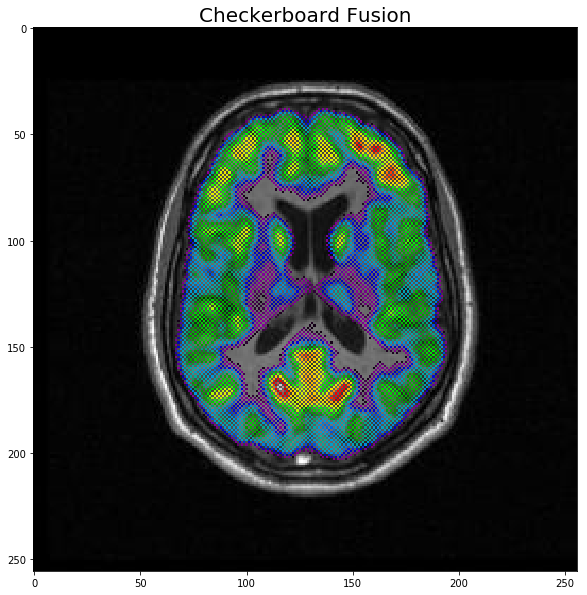

In [11]:
plt.figure(figsize=(10,10))
plt.title("Checkerboard Fusion", fontsize=20)
plt.imshow(checkerboard_fused_image)
plt.show()

*Let us move in to get a better feeling for the working principle.*

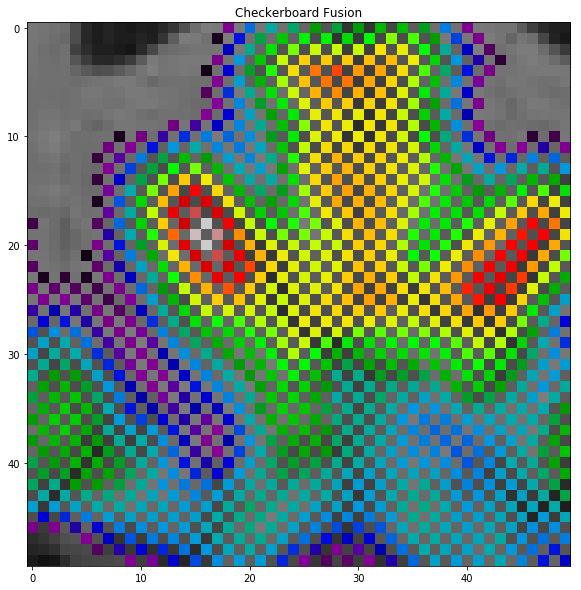

In [12]:
plt.figure(figsize=(10,10))
plt.title("Checkerboard Fusion")
plt.imshow(checkerboard_fused_image[150:200,100:150,:])
plt.show()

*An advantage of this method is that the contrast-values and the colormaps can be choosen independently. An disatvantage is that you give up half the resolution.*

*Instead of a simple overlay, one can choose to create a color-LUT to give the tuple (mr-value,pet-value) a certain value (Positron Emission Tomography - Physical Background and Applications, Habilitationsschrift, p.115, 1997, Uwe Pietrzyk). We choose an eight-bit (2^8 = 16^2) color encoding:*

In [13]:
bit_depth = 8

*Now we rescale the MR- and the PET-image to eight-bit:*

In [14]:
max_val = (2 ** bit_depth - 1)
lut_dim = np.sqrt(max_val+1).astype(np.int)
mr_image_mod_resc = (mr_image_mod / np.amax(mr_image_mod) * (lut_dim-1)).astype(np.int)
pet_image_mod_resc = (pet_image_mod / np.amax(pet_image_mod) * (lut_dim-1)).astype(np.int)

*And create the LUT:*

In [15]:
def create_lut(lut_dim):
    
    lut = np.zeros((lut_dim,lut_dim,4))

    gradient1 = np.linspace(0,1,lut_dim)
    gradient2 = np.linspace(0,1,lut_dim-1)

    gray = cm.gray(gradient1)
    rainbow = cm.rainbow(gradient2)

    lut[0,:,:] = gray
    for i in range(lut_dim):
        lut[1:,i,:] = (rainbow)

    for i in range(1,lut_dim):
        lut[i,:,:] = (0.7*lut[0,:,:] + 0.3*lut[i,:,:])

    return lut

In [16]:
lut = create_lut(lut_dim)

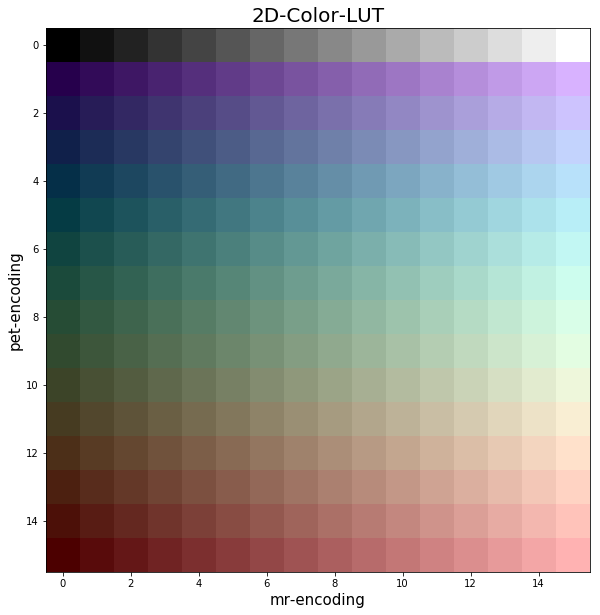

In [17]:
plt.figure(figsize=(10,10))
plt.title("2D-Color-LUT",fontsize=20)
plt.imshow(lut)
plt.xlabel("mr-encoding",fontsize=15)
plt.ylabel("pet-encoding",fontsize=15)
plt.show()

*The LUT-fusion is very simple: we just iterate over the image coordinates and choose for every tuple(x,y) the corresponding value from the LUT.*

In [18]:
lut_fused_image = np.zeros((mr_image_mod_resc.shape[0],mr_image_mod_resc.shape[1],4))

for x in range(mr_image_mod_resc.shape[0]-1):
    for y in range(mr_image_mod_resc.shape[1]):
        lut_fused_image[x,y,:] = lut[pet_image_mod_resc[x,y],mr_image_mod_resc[x,y],:]

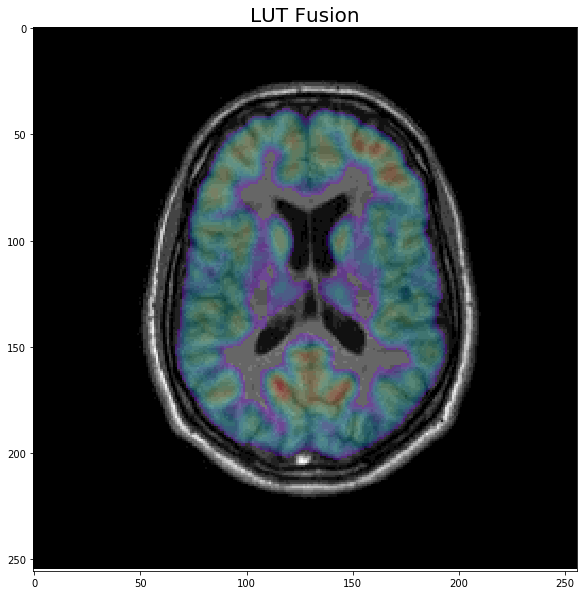

In [19]:
plt.figure(figsize=(10,10))
plt.title("LUT Fusion", fontsize=20)
plt.imshow(lut_fused_image)
plt.show()

*And for a comparison:*

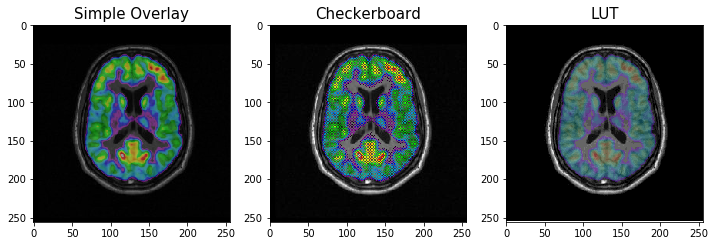

In [20]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.title("Simple Overlay",fontsize=15)
plt.imshow(mr_image_mod,cmap = "gray",alpha = 1.0)
plt.imshow(pet_image_mod,cmap = "nipy_spectral",alpha = 0.5)

plt.subplot(132)
plt.title("Checkerboard",fontsize=15)
plt.imshow(checkerboard_fused_image)

plt.subplot(133)
plt.title("LUT",fontsize=15)
plt.imshow(lut_fused_image)

plt.show()

*Tada!*